# Bayesian Automatic Outlier Detection

In [0]:
!pip install rosey

In [0]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy import stats
from scipy.special import expit
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as graph
import seaborn as sns
from rosey.graphing import plot_roc_curve


softplus = lambda x: np.log(1 + np.exp(x))

Using TensorFlow backend.


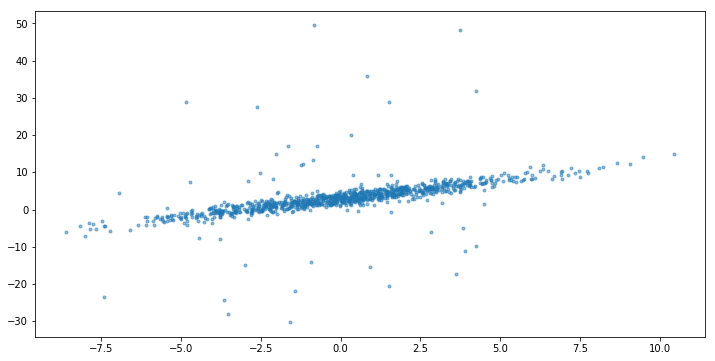

In [0]:
# Setup
n = 1000
outlier_proportion = 0.05

m, b = 1, 3
inlier_std, outlier_std = 1, 15

inliers = stats.bernoulli(1 - outlier_proportion).rvs(n)
outliers = (~inliers.astype(bool)).astype(int)

x = 3 * stats.norm().rvs(n)
y = m*x + b
y += inliers * stats.norm(0, inlier_std).rvs(n)
y += outliers * stats.norm(0, outlier_std).rvs(n)

graph.figure(figsize=(12, 6))
graph.plot(x, y, '.', alpha=0.5)
graph.show()

# Modeling Outlier Probability of Every Sample

The model is really simple. $ith$ for every sample.

$ y \sim \mathcal{N}(\mu, \sigma) $

$ \mu \sim mX + b $

$ \sigma \sim p_i \mathcal{N}(0, \sigma_{inlier})^+ + (1-p_i) \mathcal{N}(0, \sigma_{inlier} + \sigma_{outlier})^+ $

$ p_i \sim Bern(\theta_i) $

$ \theta_i \sim Unif(0, 1) $

In [0]:
# Solution
with pm.Model() as model:
    # Priors
    m = pm.Normal('m', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    
    inlier_std_rv = pm.HalfNormal('inlier_std', sd=10)
    outlier_std_rv = pm.HalfNormal('outlier_std', sd=10)
    
    outlier_prob = pm.Uniform('outlier_prob', lower=0, upper=1, shape=y.shape)
#     outlier_assign = pm.Bernoulli('outlier_assign', p=outlier_prob, shape=y.shape)
    
    # Model
    mu_hat = m*x + b
    
    # Compute Likelihood
    inliers_loglike = pm.Normal.dist(mu=mu_hat, sd=inlier_std_rv).logp(y)
    outliers_loglike = pm.Normal.dist(mu=mu_hat, sd=inlier_std_rv + outlier_std_rv).logp(y)
    
    likelihood = pm.Potential(
        'likelihood',
        ((1-outlier_prob) * inliers_loglike).sum() + (outlier_prob * outliers_loglike).sum()
    )
    
    # Sample Posterior
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [outlier_prob, outlier_std, inlier_std, b, m]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:45<00:00, 111.04draws/s]


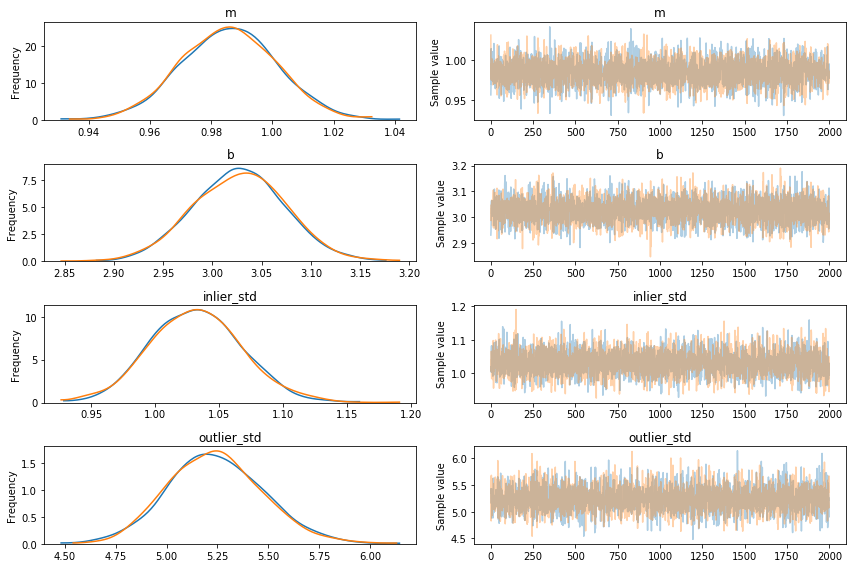

In [0]:
pm.traceplot(trace, varnames=['m', 'b', 'inlier_std', 'outlier_std'])
graph.show()

(4000, 1000)


,outlier_prob__0,outlier_prob__1,outlier_prob__2,outlier_prob__3,outlier_prob__4,outlier_prob__5,outlier_prob__6,outlier_prob__7,outlier_prob__8,outlier_prob__9,...,outlier_prob__990,outlier_prob__991,outlier_prob__992,outlier_prob__993,outlier_prob__994,outlier_prob__995,outlier_prob__996,outlier_prob__997,outlier_prob__998,outlier_prob__999
0,0.125946,0.570263,0.686594,0.096511,0.433653,0.243655,0.671359,0.121905,0.347723,0.187019,...,0.351279,0.035786,0.084540,0.082383,0.400345,0.493262,0.355343,0.124639,0.562937,0.307696
1,0.078634,0.167479,0.836869,0.121619,0.282615,0.370398,0.643992,0.128912,0.179724,0.540931,...,0.431512,0.015480,0.119064,0.043788,0.504761,0.529438,0.792894,0.098954,0.725711,0.156462
2,0.766561,0.507814,0.902661,0.452945,0.559591,0.152126,0.029344,0.743625,0.712645,0.302045,...,0.284668,0.924993,0.880373,0.814575,0.148093,0.208466,0.489764,0.950993,0.311857,0.278370
3,0.065068,0.108444,0.182158,0.222708,0.506486,0.648309,0.942374,0.149080,0.223238,0.542249,...,0.297755,0.043217,0.031577,0.000603,0.560714,0.740810,0.493885,0.142660,0.520890,0.411211
4,0.137834,0.231349,0.723729,0.567829,0.783803,0.064149,0.857440,0.098220,0.133667,0.313015,...,0.896553,0.202451,0.621336,0.023797,0.257061,0.061241,0.859811,0.272290,0.292452,0.074436


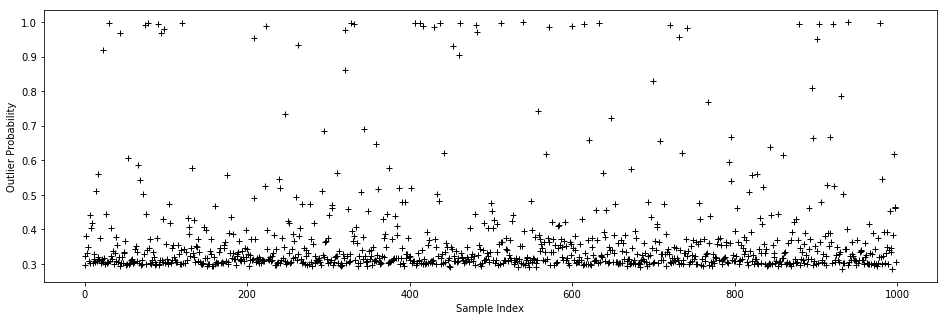

In [0]:
trace_df = pm.trace_to_dataframe(trace, varnames=['outlier_prob'])
pred_outlier_prob = trace_df.median(axis=0).values

soln = pd.DataFrame(x, columns=['x'])
soln['y'] = y
soln['outlier-prob'] = pred_outlier_prob

print(trace_df.shape)
display(trace_df.head())

graph.figure(figsize=(16, 5))
graph.plot(pred_outlier_prob, '+', color='black')
graph.ylabel('Outlier Probability')
graph.xlabel('Sample Index')
graph.show()

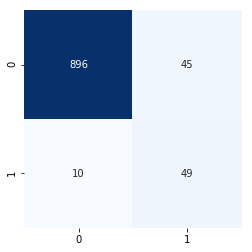

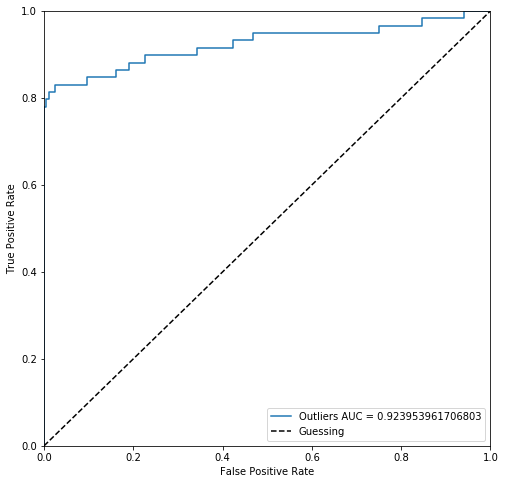

              precision    recall  f1-score   support

      inlier       0.99      0.95      0.97       941
     outlier       0.52      0.83      0.64        59

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.76      0.89      0.81      1000
weighted avg       0.96      0.94      0.95      1000

Estimated Number of Outliers @ Thresold of 50% = 0.094


In [0]:
# Sensitivity
soln['outlier-pred'] = (soln['outlier-prob'] > 0.5).astype(int)
soln['outlier-gt'] = outliers

sns.heatmap(
    confusion_matrix(soln['outlier-gt'], soln['outlier-pred']), 
    annot=True, square=True, fmt=',',
    cbar=False, cmap='Blues'
)
graph.show()

graph.figure(figsize=(8, 8))
plot_roc_curve(
    soln['outlier-prob'].values, soln['outlier-gt'].values, 
    label='Outliers'
)
graph.show()

print(classification_report(
    soln['outlier-gt'], soln['outlier-pred'], 
    target_names=['inlier', 'outlier']
))
print(f'Estimated Number of Outliers @ Thresold of 50% = {(soln["outlier-prob"] > 0.5).mean():.4}')

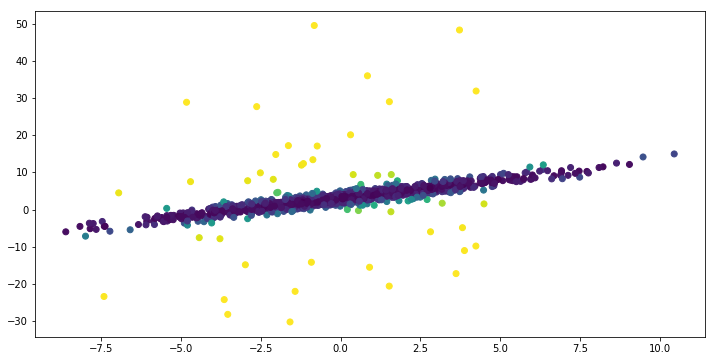

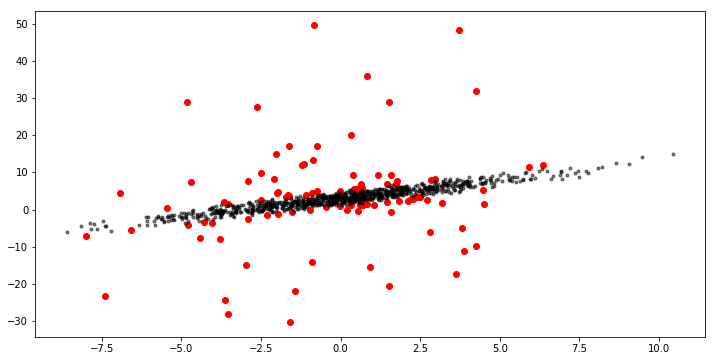

In [0]:
graph.figure(figsize=(12, 6))
graph.scatter(soln['x'], soln['y'], c=soln['outlier-prob'])
graph.show()

graph.figure(figsize=(12, 6))
graph.scatter(
    soln[soln['outlier-prob'] > 0.5]['x'], 
    soln[soln['outlier-prob'] > 0.5]['y'], 
    c='red'
)
graph.scatter(
    soln[soln['outlier-prob'] <= 0.5]['x'], 
    soln[soln['outlier-prob'] <= 0.5]['y'], 
    marker='.', alpha=0.5, c='black'
)
graph.show()

# Modeling Outliers Probability by their residual

The problem with the previous method is that the number of params to estimate increases linearly with the size of the dataset. This method would simply figure out a threshold value that outliers would be below or above on. This model adds the a strong assumption that the residuals are homoscedastic. This can be delt with by making the model that models the threshold more complex.

In [0]:
with pm.Model() as thres_model:
    # Priors
    m = pm.Normal('m', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    
    inlier_std_rv = pm.HalfNormal('inlier_std', sd=10)
    outlier_std_rv = pm.HalfNormal('outlier_std', sd=10)
    
    beta = pm.Normal('beta', mu=0, sd=100)
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    
    # Model
    mu = m*x + b
    outlier_prob = pm.Deterministic(
        'outlier_prob', 
        pm.math.invlogit(beta*abs(y-mu) + beta_0)
    )
    
    # Likelihood
    inliers_loglike = pm.Normal.dist(mu=mu, sd=inlier_std_rv).logp(y)
    outliers_loglike = pm.Normal.dist(mu=mu, sd=inlier_std_rv + outlier_std_rv).logp(y)
    
    likelihood = pm.Potential(
        'likelihood',
        ((1-outlier_prob) * inliers_loglike).sum() + (outlier_prob * outliers_loglike).sum()
    )
    
    # Posterior
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, beta, outlier_std, inlier_std, b, m]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:18<00:00, 36.17draws/s]
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


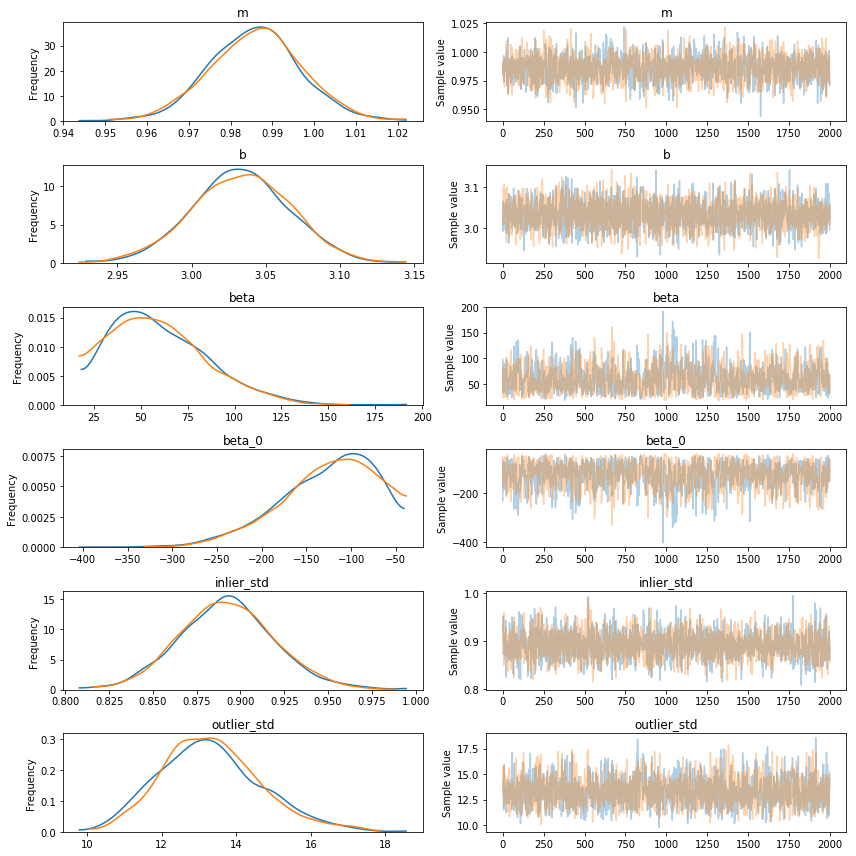

(1000, 3)


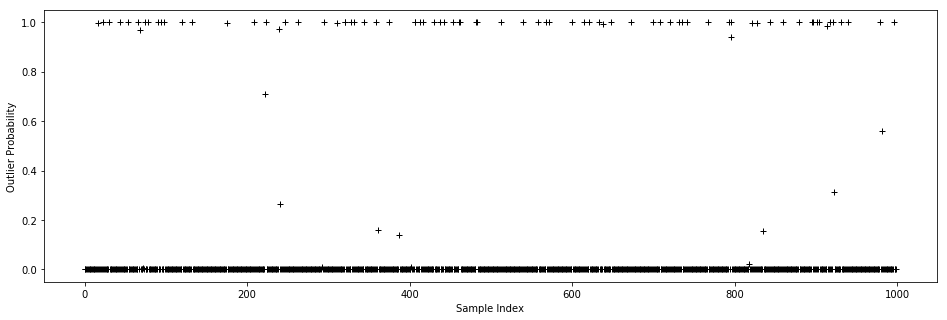

In [0]:
pm.traceplot(
    trace, 
    varnames=['m', 'b', 'beta', 'beta_0', 'inlier_std', 'outlier_std']
)
graph.show()

fast_outlier_df = pm.trace_to_dataframe(trace, varnames=['outlier_prob'])
fast_outlier_prob = fast_outlier_df.median(axis=0).values

fast_outlier_df = pd.DataFrame(x, columns=['x'])
fast_outlier_df['y'] = y
fast_outlier_df['outlier-prob'] = fast_outlier_prob

print(fast_outlier_df.shape)


graph.figure(figsize=(16, 5))
graph.plot(fast_outlier_prob, '+', color='black')
graph.ylabel('Outlier Probability')
graph.xlabel('Sample Index')
graph.show()

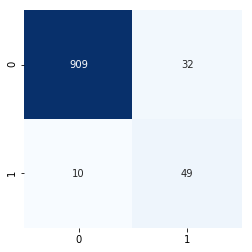

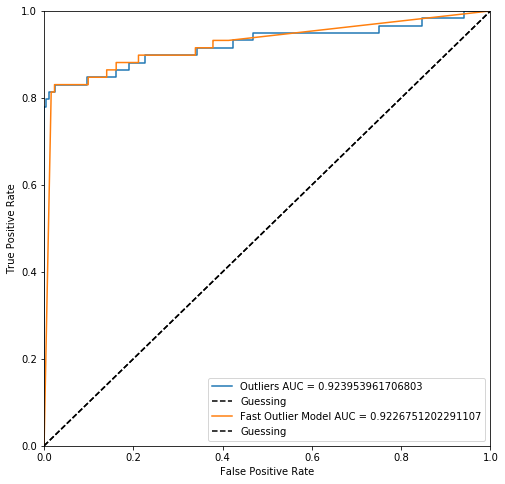

              precision    recall  f1-score   support

      inlier       0.99      0.97      0.98       941
     outlier       0.60      0.83      0.70        59

   micro avg       0.96      0.96      0.96      1000
   macro avg       0.80      0.90      0.84      1000
weighted avg       0.97      0.96      0.96      1000

Estimated Number of Outliers @ Thresold of 50% = 0.081


In [0]:
# Sensitivity
fast_outlier_df['outlier-pred'] = (fast_outlier_df['outlier-prob'] > 0.5).astype(int)
fast_outlier_df['outlier-gt'] = outliers

sns.heatmap(
    confusion_matrix(fast_outlier_df['outlier-gt'], 
                     fast_outlier_df['outlier-pred']), 
    annot=True, square=True, fmt=',',
    cbar=False, cmap='Blues'
)
graph.show()

graph.figure(figsize=(8, 8))
plot_roc_curve(
    soln['outlier-prob'].values, soln['outlier-gt'].values, 
    label='Outliers'
)
plot_roc_curve(
    fast_outlier_df['outlier-prob'].values, 
    fast_outlier_df['outlier-gt'].values, 
    label='Fast Outlier Model'
)
graph.show()

print(classification_report(fast_outlier_df['outlier-gt'], fast_outlier_df['outlier-pred'], target_names=['inlier', 'outlier']))
print(f'Estimated Number of Outliers @ Thresold of 50% = {(fast_outlier_df["outlier-prob"] > 0.5).mean():.4}')

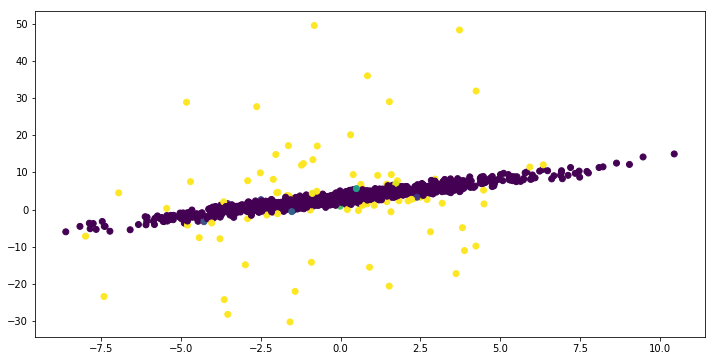

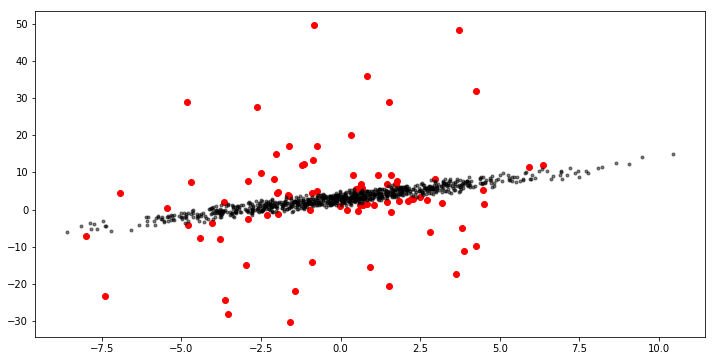

In [0]:
graph.figure(figsize=(12, 6))
graph.scatter(
    fast_outlier_df['x'], 
    fast_outlier_df['y'], 
    c=fast_outlier_df['outlier-prob']
)
graph.show()

graph.figure(figsize=(12, 6))
graph.scatter(
    fast_outlier_df[fast_outlier_df['outlier-prob'] > 0.5]['x'], 
    fast_outlier_df[fast_outlier_df['outlier-prob'] > 0.5]['y'], 
    c='red'
)
graph.scatter(
    fast_outlier_df[fast_outlier_df['outlier-prob'] <= 0.5]['x'], 
    fast_outlier_df[fast_outlier_df['outlier-prob'] <= 0.5]['y'], 
    marker='.', alpha=0.5, c='black'
)
graph.show()

# Maximum Likelihood Outlier Estimation

Since both the solutions are smooth and convex it should be easy to optimise for directly. I'll only try MLE optimisation of the inverse logit method since it should be easier computationally.

**NOTE:** This method can definitely be rewritten for detecting outliers from only the residuals. Of course this assumes that the outliers does not considerably affect the model's fit.

In [0]:
def likelihood(params, x, y):
    # Has an embedded linear regression function (6 params)
    m, b, beta, beta_0, sd_inlier, sd_outlier = params
    
    # Constrain sd params
    sd_inlier, sd_outlier = softplus(sd_inlier), softplus(sd_outlier)
    sd_outlier += sd_inlier
    
    # Model
    y_hat = m*x + b
    res = y - y_hat
    
    outlier_p = expit(beta * np.abs(res) + beta_0)
    
    # Log-likelihood
    inlier_loglikelihood = (1-outlier_p) * stats.norm(0, sd_inlier).logpdf(res)
    outlier_loglikelihood = outlier_p * stats.norm(0, sd_outlier).logpdf(res)
    loglikelihood = -(inlier_loglikelihood.sum() + outlier_loglikelihood.sum())
    return -loglikelihood

In [0]:
%%time
m, b, beta, beta_0, sd_in, sd_out = opt.fmin(
    likelihood, np.ones(6), args=(x, y)
)
print(m, b)
print(beta, beta_0)

8.185616616645266 11.989635580728656
14.444238885748295 -30.25921894135942
CPU times: user 2.29 s, sys: 553 µs, total: 2.29 s
Wall time: 2.3 s
